# **Punto 1.7**
Un teatro utiliza un empleado para vender tiquetes y responder consultas desde las 9 a. m hasta las 5 p. m. Los puestos se adjudican únicamente si el cliente llega al teatro y paga por los tiquetes. Consultas provienen de clientes en persona o de llamadas al teatro y El empleado da prioridad a los clientes en persona. Sin embargo, gracias a un sistema complejo telefónico, las llamadas pueden esperar para ser atendidos según la política FIFO (primero en llegar primero en salir) y no renuncian hasta obtener una respuesta. Los clientes en persona llegan según una distribución exponencial con media de 12 minutos y su tiempo de servicio se distribuye exponencial con media de 6 minutos. Las llamadas ocurren según una distribución exponencial con media de 10 minutos y su tiempo de servicio sigue una distribución exponencial con media de 5 minutos. La primera persona llega a los 2 minutos y la primera llamada a los 3 minutos. Simular este sistema para un día de 8 horas y obtenga el tiempo de espera promedio de cada tipo de cliente.

# **Especificaciones de la simulación**
Se nos da la media para cada la llegada de cada tipo de cliente y sus salidas, así como la llegada del primer cliente para cada tipo. A su vez el tiempo de ls simulación es de 480 minutos.

# **Código completo de la simulación**
Este código corre la simulación con las estadísticas deseadas, que son el tiempo promedio de demora cada cliente. Recordar que esta estadística se toma desde que el cliente entra a la cola hasta que finaliza el servicio.

In [1]:
import numpy as np
np.random.seed(2)

class Theatre_Queue:
    """Definir la clase"""
    def __init__(self, tiempo_total):
        """Inicializacion de la funcion"""

        # Parámetros de entrada
        self.media_entre_llegada_fisica = 12.0
        self.media_entre_llegada_telefonica = 10.0
        self.media_servicio_fisico = 6.0
        self.media_servicio_telefonico = 5.0
        self.tiempo_total = tiempo_total #tiempo total de la simulacion

        # Variables de estado
        self.estado_servidor = 0 # 0 es disponible y 1 es ocupado
        self.numero_clientes_cola_fisica = 0
        self.numero_clientes_cola_telefonica = 0
        self.tiempo_llegada_fisica = [] # Lista para el tiempo de llegada fisica
        self.tiempo_llegada_telefonica = [] # Lista para el tiempo de llegada telefonica
        self.tiempo_ultimo_evento = 0.0

        # Contadores estadísticos
        self.num_clientes_fisicos_demorados = 0
        self.num_clientes_telefonicos_demorados = 0
        self.total_demora_fisica = 0.0
        self.total_demora_telefonica = 0.0
        self.area_numero_clientes_cola_fisica = 0.0
        self.area_numero_clientes_cola_telefonica = 0.0
        self.area_estado_servidor = 0.0

        # Reloj de simulación
        self.sim_time = 0.0

        # Lista de eventos
        self.tiempo_siguiente_evento = [0,0,0,0,0] #Esta lista tiene 3 entradas, con el índice 0 no usado
        # 1 llegada fisica, 2 llegada telefonica, 3 salida, 4 parametro de salida de la simulacion
        self.tiempo_siguiente_evento[1] = 2.000
        self.tiempo_siguiente_evento[2] = 3.000
        self.tiempo_siguiente_evento[3] = float('inf')
        self.tiempo_siguiente_evento[4] = self.tiempo_total

        # Otras variables
        self.num_events = 4

    def main(self):

        print("-"*40)
        print("Simulacion de teatro")
        print("Media de llegada entre clientes fisicos: {:.3f} minutos".format(self.media_entre_llegada_fisica))
        print("Media de llegada entre clientes telefonicos: {:.3f} minutos".format(self.media_entre_llegada_telefonica))
        print("Media de servicio en el servicio fisico: {:.3f} minutos".format(self.media_servicio_fisico))
        print("Media de servicio en el servicio telefonico: {:.3f} minutos".format(self.media_servicio_telefonico))
        print("Numero de minutos hasta el fin de la simulacion: {} minutos".format(self.tiempo_total))
        print("-"*40)

        while True:

            # Determina cuál es el próximo evento
            self.timing()

            # Actualiza las estadísticas
            self.update_time_avg_stats()

            # Llama la función que le corresponde al evento (tipo 1 es llegada fisica, tipo 2 llegada telefonica, tipo 3 salida y el 4 es el fin de la simulacion)
            if(self.tipo_siguiente_evento == 1):
                self.arrivalPhysicalDF()
            elif(self.tipo_siguiente_evento == 2):
                self.arrivalTelephoneDF()
            elif(self.tipo_siguiente_evento == 3):
                self.departureDF()
            elif(self.tipo_siguiente_evento == 4):
                break

        #se finaliza con un reporte de los resultados de la simulacion
        self.report()

    #funcion de generacion de numeros aleatorios
    def expon(self, mean):
        return (-mean * np.log(np.random.uniform(0,1)))

    #funcion para determinar el siguiente evento de la simulacion
    def timing(self):

        self.minuto_siguiente_evento = float('inf')
        self.tipo_siguiente_evento = 0

        #Inicia comparando inf con el primer elemento de la lista de eventos, posteriormente compara el resto de la lista buscando el valor de tiempo mas pequeño
        for i in range(1, self.num_events+1):
            if(self.tiempo_siguiente_evento[i]<self.minuto_siguiente_evento):
                self.minuto_siguiente_evento = self.tiempo_siguiente_evento[i]
                self.tipo_siguiente_evento = i

        if (self.tipo_siguiente_evento == 0) :
            raise Exception ("Toda entrada en la lista de eventos es infinita, se opta por finalizar la simulacion")

        # El reloj de la simulacion avanza al menor valor numerico posible, es decir, al evento mas cercano
        self.sim_time = self.minuto_siguiente_evento

    def arrivalPhysicalDF(self):
        #Se agenda una nueva llegada fisica
        self.tiempo_siguiente_evento[1] = self.sim_time + self.expon(self.media_entre_llegada_fisica)

        #Si el server está ocupado simplemente se agrega al cliente a la cola, así como su tiempo de llegada
        if(self.estado_servidor == 1):
            self.numero_clientes_cola_fisica+=1
            self.tiempo_llegada_fisica.append(self.sim_time)
        else:
            self.delay = 0.0
            self.total_demora_fisica+=self.delay

            self.num_clientes_fisicos_demorados += 1
            self.estado_servidor = 1

            self.tiempo_siguiente_evento[3] = self.sim_time + self.expon(self.media_servicio_fisico)

    def arrivalTelephoneDF(self):
        #La explicación de este método es recíproca al de arrivalPhysical
        self.tiempo_siguiente_evento[2] = self.sim_time + self.expon(self.media_entre_llegada_telefonica)

        if(self.estado_servidor == 1):
            self.numero_clientes_cola_telefonica+=1
            self.tiempo_llegada_telefonica.append(self.sim_time)
        else:
            self.delay = 0.0
            self.total_demora_telefonica+=self.delay

            self.num_clientes_telefonicos_demorados += 1
            self.estado_servidor = 1

            self.tiempo_siguiente_evento[3] = self.sim_time + self.expon(self.media_servicio_telefonico)

    def departureDF(self):
        # Verifica si la cola fisica está vacía
        if (self.numero_clientes_cola_fisica == 0):
            # Verifica que la cola telefonica este vacia
            if(self.numero_clientes_cola_telefonica == 0):
                self.estado_servidor = 0
                self.tiempo_siguiente_evento[3] = float('inf')

            #En caso de no estarlo, el siguiente cliente telefonico ocupa el servicio
            else:
                self.numero_clientes_cola_telefonica -= 1

                self.delay = self.sim_time - self.tiempo_llegada_telefonica[0]
                self.total_demora_telefonica += self.delay

                #Incrementa le número de clientes atendidos telefónicamente y agenda una partida
                self.num_clientes_telefonicos_demorados += 1
                self.tiempo_siguiente_evento[3] = self.sim_time + self.expon(self.media_servicio_telefonico)

                del self.tiempo_llegada_telefonica [0]

        else: # Si la cola fisica no esta vacia

            self.numero_clientes_cola_fisica -= 1

            # Calcula la demora del cliente que empieza el sevicio
            self.delay = self.sim_time - self.tiempo_llegada_fisica[0]
            self.total_demora_fisica += self.delay

            # Incrementa el número de clientes presenciales atendidos y agenda una partida
            self.num_clientes_fisicos_demorados += 1
            self.tiempo_siguiente_evento[3] = self.sim_time + self.expon(self.media_servicio_fisico)

            # Elimina el cliente que está de primeras en la fila
            del self.tiempo_llegada_fisica [0]

    def report(self):

        print("Número de clientes que tuvieron servicio físico {} clientes".format(self.num_clientes_fisicos_demorados))
        print("Número de clientes que tuvieron servicio telefonico {} clientes".format(self.num_clientes_telefonicos_demorados))
        print("Media de demora física: {:.3f} minutos".format(self.total_demora_fisica/self.num_clientes_fisicos_demorados))
        print("Media de demora telefónica: {:.3f} minutos".format(self.total_demora_telefonica/self.num_clientes_telefonicos_demorados))
        print("Media de clientes en la fila física: {:.3f} clientes".format(self.area_numero_clientes_cola_fisica/self.sim_time))
        print("Media de clientes en al fila telefónica: {:.3f} clientes".format(self.area_numero_clientes_cola_telefonica/self.sim_time))
        print("Utilización del servicio: {:.3f} del tiempo total".format(self.area_estado_servidor/self.sim_time))
        print("Tiempo total de simulación: {:.3f} minutes".format(self.sim_time))
        print("-"*40)

    def update_time_avg_stats(self):

        #Calcula el tiempo desde el último evento
        self.time_since_last_event = self.sim_time - self.tiempo_ultimo_evento
        self.tiempo_ultimo_evento = self.sim_time

        # Actualiza el área bajo la curva de la variable número en cola
        self.area_numero_clientes_cola_fisica += self.numero_clientes_cola_fisica * self.time_since_last_event
        self.area_numero_clientes_cola_telefonica += self.numero_clientes_cola_telefonica * self.time_since_last_event
        self.area_estado_servidor += self.estado_servidor * self.time_since_last_event

    #Método sin reportes, se usa para la recolección de datos en varias simulaciones evitando los prints de cada una de las simulaciones
    def mainNoReport(self):
      while True:
            # Determina cuál es el próximo evento
            self.timing()

            # Actualiza las estadísticas
            self.update_time_avg_stats()

            # Llama la función que le corresponde al evento (tipo 1 es llegada fisica, tipo 2 llegada telefonica, tipo 3 salida y el 4 es el fin de la simulacion)
            if(self.tipo_siguiente_evento == 1):
                self.arrivalPhysicalDF()
            elif(self.tipo_siguiente_evento == 2):
                self.arrivalTelephoneDF()
            elif(self.tipo_siguiente_evento == 3):
                self.departureDF()
            elif(self.tipo_siguiente_evento == 4):
                break

    def mainNoReportDS(self):
      while True:
            # Determina cuál es el próximo evento
            self.timing()

            # Actualiza las estadísticas
            self.update_time_avg_stats()

            # Llama la función que le corresponde al evento (tipo 1 es llegada fisica, tipo 2 llegada telefonica, tipo 3 salida y el 4 es el fin de la simulacion)
            if(self.tipo_siguiente_evento == 1):
                self.arrivalPhysicalDS()
            elif(self.tipo_siguiente_evento == 2):
                self.arrivalTelephoneDS()
            elif(self.tipo_siguiente_evento == 3):
                self.departureDS()
            elif(self.tipo_siguiente_evento == 4):
                break
    def arrivalPhysicalDS(self):
        #Se agenda una nueva llegada fisica
        self.tiempo_siguiente_evento[1] = self.sim_time + self.expon(self.media_entre_llegada_fisica)

        #Si el server está ocupado simplemente se agrega al cliente a la cola, así como su tiempo de llegada
        if(self.estado_servidor == 1):
            self.numero_clientes_cola_fisica+=1
            self.tiempo_llegada_fisica.append(self.sim_time)
        else:
            self.delay = 0.0
            self.total_demora_fisica+=self.delay

            self.estado_servidor = 1

            self.tiempo_siguiente_evento[3] = self.sim_time + self.expon(self.media_servicio_fisico)
            if (self.tiempo_siguiente_evento[3] < self.tiempo_total):
              self.total_demora_fisica += self.tiempo_siguiente_evento[3] - self.sim_time


    def arrivalTelephoneDS(self):
        #La explicación de este método es recíproca al de arrivalPhysical
        self.tiempo_siguiente_evento[2] = self.sim_time + self.expon(self.media_entre_llegada_telefonica)

        if(self.estado_servidor == 1):
            self.numero_clientes_cola_telefonica+=1
            self.tiempo_llegada_telefonica.append(self.sim_time)
        else:
            self.delay = 0.0
            self.total_demora_telefonica+=self.delay

            self.estado_servidor = 1

            self.tiempo_siguiente_evento[3] = self.sim_time + self.expon(self.media_servicio_telefonico)
            if (self.tiempo_siguiente_evento[3] < self.tiempo_total):
              self.total_demora_telefonica += self.tiempo_siguiente_evento[3] - self.sim_time


    def departureDS(self):
        # Verifica si la cola fisica está vacía
        if (self.numero_clientes_cola_fisica == 0):
            # Verifica que la cola telefonica este vacia
            if(self.numero_clientes_cola_telefonica == 0):
                self.estado_servidor = 0
                self.tiempo_siguiente_evento[3] = float('inf')

            #En caso de no estarlo, el siguiente cliente telefonico ocupa el servicio
            else:
                self.numero_clientes_cola_telefonica -= 1

                self.delay = self.sim_time - self.tiempo_llegada_telefonica[0]
                self.total_demora_telefonica += self.delay

                self.num_clientes_telefonicos_demorados += 1
                self.tiempo_siguiente_evento[3] = self.sim_time + self.expon(self.media_servicio_telefonico)

                del self.tiempo_llegada_telefonica [0]
                if (self.tiempo_siguiente_evento[3] < self.tiempo_total):
                  self.total_demora_telefonica += self.tiempo_siguiente_evento[3] - self.sim_time

        else: # Si la cola fisica no esta vacia

            self.numero_clientes_cola_fisica -= 1

            # Calcula la demora del cliente que empieza el sevicio
            self.delay = self.sim_time - self.tiempo_llegada_fisica[0]
            self.total_demora_fisica += self.delay

            # Incrementa el número de clientes retrasados y agenda una partida
            self.num_clientes_fisicos_demorados += 1
            self.tiempo_siguiente_evento[3] = self.sim_time + self.expon(self.media_servicio_fisico)

            # Elimina el cliente que está de primeras en la fila
            del self.tiempo_llegada_fisica [0]
            if (self.tiempo_siguiente_evento[3] < self.tiempo_total):
              self.total_demora_fisica += self.tiempo_siguiente_evento[3] - self.sim_time


m = Theatre_Queue(480)
m.main()

----------------------------------------
Simulacion de teatro
Media de llegada entre clientes fisicos: 12.000 minutos
Media de llegada entre clientes telefonicos: 10.000 minutos
Media de servicio en el servicio fisico: 6.000 minutos
Media de servicio en el servicio telefonico: 5.000 minutos
Numero de minutos hasta el fin de la simulacion: 480 minutos
----------------------------------------
Número de clientes que tuvieron servicio físico 41 clientes
Número de clientes que tuvieron servicio telefonico 37 clientes
Media de demora física: 6.824 minutos
Media de demora telefónica: 40.142 minutos
Media de clientes en la fila física: 0.583 clientes
Media de clientes en al fila telefónica: 3.501 clientes
Utilización del servicio: 0.996 del tiempo total
Tiempo total de simulación: 480.000 minutes
----------------------------------------


# **Resultados**
Para obtener la media del tiempo de espera para cada cliente se requiere saber el tiempo total de las demoras de los clientes y dividirlos sobre el número total de clientes llegados al servicio, esto por supuesto para cada tipo de cliente.
En estos resultados se añade un intervalo de confianza del 95%
**En esta primera tabla de resultados se toma que la espera de un cliente va desde que entra la fila hasta que entra al servicio.**

Tiempo de espera promedio para clientes en persona: 9.357 minutos
Intervalo de confianza (95%) para clientes en persona: [ 8.918 , 9.795 ]
Tiempo de espera promedio para clientes telefónicos: 53.937 minutos
Intervalo de confianza (95%) para clientes telefónicos: [ 49.598 , 58.277 ]



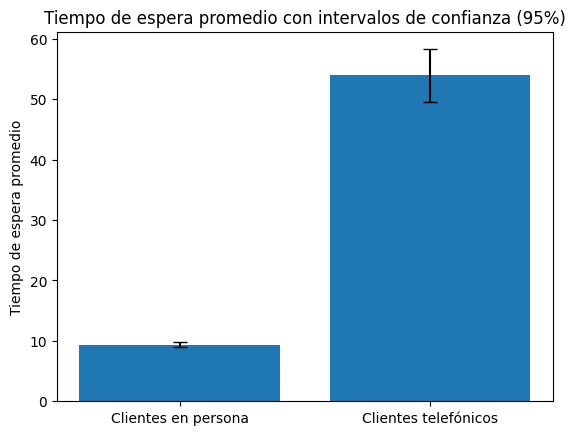

In [6]:
import matplotlib.pyplot as plt
def run_simulation(tiempo_total,seed):
    # Cambiamos la semilla de forma aleatoria en cada simulación
    np.random.seed(seed)
    m = Theatre_Queue(tiempo_total)
    m.mainNoReport()
    return m.total_demora_fisica / m.num_clientes_fisicos_demorados, m.total_demora_telefonica / m.num_clientes_telefonicos_demorados

# Parámetros
num_simulaciones = 350
tiempo_total = 8 * 60  # 8 horas en minutos

# Listas para almacenar resultados
tiempos_espera_fisico = []
tiempos_espera_telefonico = []

# Ejecutar las simulaciones
for i in range(num_simulaciones):
    espera_fisico, espera_telefonico = run_simulation(tiempo_total, i)
    tiempos_espera_fisico.append(espera_fisico)
    tiempos_espera_telefonico.append(espera_telefonico)

# Calcular estadísticas
media_espera_fisico = np.mean(tiempos_espera_fisico)
media_espera_telefonico = np.mean(tiempos_espera_telefonico)
std_error_fisico = np.std(tiempos_espera_fisico) / np.sqrt(num_simulaciones)
std_error_telefonico = np.std(tiempos_espera_telefonico) / np.sqrt(num_simulaciones)

# Calcular intervalos de confianza al 95%
intervalo_confianza_fisico = 1.96 * std_error_fisico
intervalo_confianza_telefonico = 1.96 * std_error_telefonico

# Imprimir resultados
print("Tiempo de espera promedio para clientes en persona:", round(media_espera_fisico,3), "minutos")
print("Intervalo de confianza (95%) para clientes en persona:","[",round(media_espera_fisico - intervalo_confianza_fisico,3),",",round(media_espera_fisico + intervalo_confianza_fisico,3),"]")
print("Tiempo de espera promedio para clientes telefónicos:", round(media_espera_telefonico,3), "minutos")
print("Intervalo de confianza (95%) para clientes telefónicos:","[",round(media_espera_telefonico - intervalo_confianza_telefonico,3),",",round(media_espera_telefonico + intervalo_confianza_telefonico,3),"]")
print()

# Graficar resultados
fig, ax = plt.subplots()
ax.bar(["Clientes en persona", "Clientes telefónicos"], [media_espera_fisico, media_espera_telefonico], yerr=[intervalo_confianza_fisico, intervalo_confianza_telefonico], capsize=5)
ax.set_ylabel('Tiempo de espera promedio')
ax.set_title('Tiempo de espera promedio con intervalos de confianza (95%)')
plt.show()

# **¿Y si se toma otra medida para la demora?**
Por otro lado, en esta grafica se toma que la demora del cliente va desde que entra a la cola hasta que sale del servicio

Tiempo de espera promedio para clientes en persona: 17.185 minutos
Intervalo de confianza (95%) para clientes en persona: [ 16.708 , 17.662 ]
Tiempo de espera promedio para clientes telefónicos: 64.404 minutos
Intervalo de confianza (95%) para clientes telefónicos: [ 60.086 , 68.723 ]



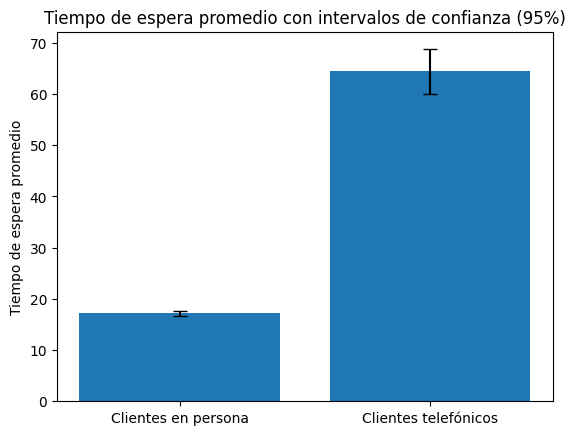

In [7]:
def run_simulationND(tiempo_total,seed):
    # Cambiamos la semilla de forma aleatoria en cada simulación
    np.random.seed(seed)
    n = Theatre_Queue(tiempo_total)
    n.mainNoReportDS()
    return n.total_demora_fisica / n.num_clientes_fisicos_demorados, n.total_demora_telefonica / n.num_clientes_telefonicos_demorados

# Parámetros
num_simulaciones = 350
tiempo_total = 8 * 60  # 8 horas en minutos

# Listas para almacenar resultados
tiempos_espera_fisico = []
tiempos_espera_telefonico = []

# Ejecutar las simulaciones
for i in range(num_simulaciones):
    espera_fisico, espera_telefonico = run_simulationND(tiempo_total, i)
    tiempos_espera_fisico.append(espera_fisico)
    tiempos_espera_telefonico.append(espera_telefonico)

# Calcular estadísticas
media_espera_fisico = np.mean(tiempos_espera_fisico)
media_espera_telefonico = np.mean(tiempos_espera_telefonico)
std_error_fisico = np.std(tiempos_espera_fisico) / np.sqrt(num_simulaciones)
std_error_telefonico = np.std(tiempos_espera_telefonico) / np.sqrt(num_simulaciones)

# Calcular intervalos de confianza al 95%
intervalo_confianza_fisico = 1.96 * std_error_fisico
intervalo_confianza_telefonico = 1.96 * std_error_telefonico

# Imprimir resultados
print("Tiempo de espera promedio para clientes en persona:", round(media_espera_fisico,3), "minutos")
print("Intervalo de confianza (95%) para clientes en persona:", "[",round(media_espera_fisico - intervalo_confianza_fisico,3),",", round(media_espera_fisico + intervalo_confianza_fisico,3),"]")
print("Tiempo de espera promedio para clientes telefónicos:", round(media_espera_telefonico,3), "minutos")
print("Intervalo de confianza (95%) para clientes telefónicos:","[" ,round(media_espera_telefonico - intervalo_confianza_telefonico,3),",", round(media_espera_telefonico + intervalo_confianza_telefonico,3),"]")
print()

# Graficar resultados
fig, ax = plt.subplots()
ax.bar(["Clientes en persona", "Clientes telefónicos"], [media_espera_fisico, media_espera_telefonico], yerr=[intervalo_confianza_fisico, intervalo_confianza_telefonico], capsize=5)
ax.set_ylabel('Tiempo de espera promedio')
ax.set_title('Tiempo de espera promedio con intervalos de confianza (95%)')
plt.show()